### Ermittlung der Periodendauer der Sonnenfleckenaktivität durch Zeitreihenanalyse

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import autocorrelation_plot
from pandas import Series
import scipy.signal as sp
import numpy as np
from spectrum import *
%matplotlib inline

Die Aktivität der Sonnenflecken besitzt Einflüsse auf das Erdmagnetfeld, das Weltraumwetter, welches für den Betrieb von Satelliten wichtig ist und auch für den Betrieb elektrischer Einrichtungen und von Telekommunikationsanlagen auf der Erde.
In früheren Zeiten konnte auch ein Einfluss auf das Erdklima beobachtet werden, in der jüngeren Vergangenheit dominiert hier jedoch der vom Menschen verursachte Klimawandel. 

Die Anzahl der Sonnenflecken pro Jahr wird seit 1749 gezählt und steht inzwischen auch zum Download bereit:
https://wwwbis.sidc.be/silso/datafiles#total

In [2]:
testdata = pd.read_csv("SN_y_tot_V2.0.csv",delimiter ="; ", engine = 'python')
testdata.head()

,Year,Sunspots,C3,C4,C5
0,1700.5,8.3,-1.0;-1;1,NaN,NaN
1,1701.5,18.3,-1.0;-1;1,NaN,NaN
2,1702.5,26.7,-1.0;-1;1,NaN,NaN
3,1703.5,38.3,-1.0;-1;1,NaN,NaN
4,1704.5,60.0,-1.0;-1;1,NaN,NaN


<Axes: >

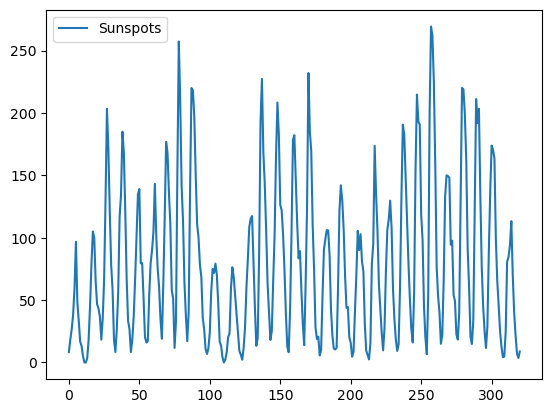

In [3]:
#testdata.plot(x='Year',y='Sunspots')
testdata.plot(y='Sunspots')
#plt.figure()
#plt.plot(testdata.Sunspots)

Die Schätzung von AR-Modellen geht von mittelwertfreien Zeitreihen aus. Daher wird als erstes der Mittelwert entfernt.

In [4]:
testdata['Sunspots_AC'] = testdata.Sunspots - testdata.Sunspots.mean()

In [5]:
testdata.head()

,Year,Sunspots,C3,C4,C5,Sunspots_AC
0,1700.5,8.3,-1.0;-1;1,NaN,NaN,-70.217134
1,1701.5,18.3,-1.0;-1;1,NaN,NaN,-60.217134
2,1702.5,26.7,-1.0;-1;1,NaN,NaN,-51.817134
3,1703.5,38.3,-1.0;-1;1,NaN,NaN,-40.217134
4,1704.5,60.0,-1.0;-1;1,NaN,NaN,-18.517134


<Axes: xlabel='Year'>

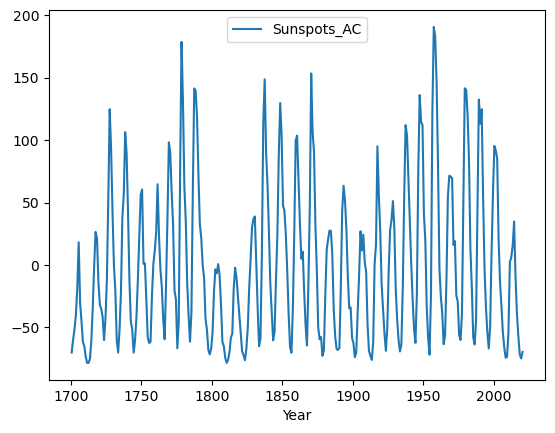

In [6]:
testdata.plot(x='Year',y='Sunspots_AC')

Ein autoregressives Modell nach Yule-Walker kann mit vorhandenen Funktionen, bspw aus dem Paket spectrum berechnet werden.

In [7]:
#AR, P, k = aryule(testdata.Sunspots_AC, 2)

Alternativ kann ein AR(2) Modell geschätzt werden.  

$u(k) = b_1 u(k-1) + b_2 u(k-2) + v(k) $

Hierzu werden die Beobachtungen in Matrixform gebracht, das lineare Gleichungssystem aufgestellt und durch die Python-Funktion lstsq gelöst.


In [8]:
# Aufbau der Regressionsmatrix und des Vektors für die rechte Seite
phi = np.zeros((len(testdata.Sunspots_AC),2))
u = np.zeros((len(testdata.Sunspots_AC),1))
 
for i in range(2,len(testdata.Sunspots_AC)): # Auftellen des Gleichungssystemes: p[0]= a,p[1]= b
    phi[i,0] = testdata.Sunspots_AC[i-1]
    phi[i,1] = testdata.Sunspots_AC[i-2]
    u[i,0] = testdata.Sunspots_AC[i]
  
AR, residuals, rank, s = np.linalg.lstsq(phi,u,-1)

AR = -AR

Transformation in den Frequenzbereich: Berechnung des Leistungsdichtespektrums. Es ergibt sich eine Darstellung mit einer Frequenz in der Einheit [1/Jahre] Entsprechend kann die Periodizität im Diagramm einfach abgelesen werden

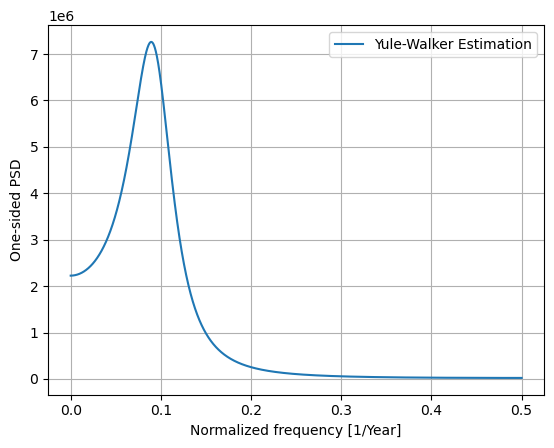

In [9]:
PSD = arma2psd(A=AR, rho=residuals)
PSD = PSD[4096:2048:-1]
plt.figure()
plt.plot(linspace(0, 0.5 , len(PSD)), PSD, label='Yule-Walker Estimation')
plt.xlabel('Normalized frequency [1/Year]')
plt.ylabel('One-sided PSD')
plt.legend()
plt.savefig('YWestimation.svg')
plt.grid()

Die Periodendauer kann aber auch direkt aus den Parametern bestimmt werden. Hierzu wird die Nullstelle des charakteristischen Polynoms berechnet.

In [10]:
AR

array([[-1.38530008],
       [ 0.69292643]])

In [11]:
ARpoly = np.append(1, AR)
print(ARpoly)

[ 1.         -1.38530008  0.69292643]


In [12]:
p = np.roots(ARpoly)
print(p)

[0.69265004+0.46169509j 0.69265004-0.46169509j]


In [13]:
f = 1/(2*np.pi) * np.arctan(np.imag(p[0])/np.real(p[0]))

In [14]:
print(1/f)

10.686942783324046
